##Importing Libraries & Loading Data 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, KFold,GroupKFold
from sklearn.metrics import mean_squared_error
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from sklearn.utils import compute_class_weight

import nltk 
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from textblob import Word
import joblib
from nltk.stem import WordNetLemmatizer
import itertools

nltk.download('punkt')

from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df=pd.read_csv('/content/drive/MyDrive/AIM_Task/cleaned_data.csv',lineterminator='\n')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458197 entries, 0 to 458196
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          458197 non-null  int64 
 1   dialect     458197 non-null  object
 2   tweet       458197 non-null  object
 3   label       458197 non-null  int64 
 4   clean_text  458180 non-null  object
dtypes: int64(2), object(3)
memory usage: 17.5+ MB


##Basic Exploratory Data Analysis (EDA) and Feature Engineering

In [3]:
df["dialect"].value_counts()

EG    57636
PL    43742
KW    42109
LY    36499
QA    31069
JO    27921
LB    27617
SA    26832
AE    26296
BH    26292
OM    19116
SY    16242
DZ    16183
IQ    15497
SD    14434
MA    11539
YE     9927
TN     9246
Name: dialect, dtype: int64

In [4]:
labels_dec = dict(zip( np.unique(df["label"]),np.unique(df["dialect"])))
labels_dec

{0: 'AE',
 1: 'BH',
 2: 'DZ',
 3: 'EG',
 4: 'IQ',
 5: 'JO',
 6: 'KW',
 7: 'LB',
 8: 'LY',
 9: 'MA',
 10: 'OM',
 11: 'PL',
 12: 'QA',
 13: 'SA',
 14: 'SD',
 15: 'SY',
 16: 'TN',
 17: 'YE'}

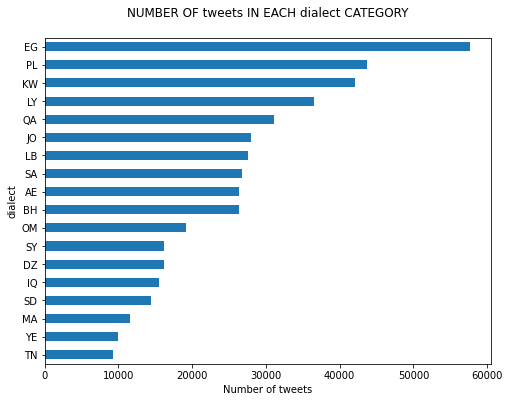

In [5]:
fig = plt.figure(figsize=(8,6))

df.groupby('dialect').dialect.count().sort_values().plot.barh(
    ylim=0, title= 'NUMBER OF tweets IN EACH dialect CATEGORY\n')
plt.xlabel('Number of tweets', fontsize = 10);

### Split Data into Training / Test 

In [3]:
y=df.label
x_train, x_test, y_train, y_test = train_test_split(df.clean_text.values.astype('U'),y, stratify=y, random_state=42, test_size=0.1, shuffle=True)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(412377,)
(45820,)
(412377,)
(45820,)


### Helper Functions 

In [4]:
def class_weights(df,col):
  """create "balanced" class weights for given data set.
     returns:class weights list and class weights dectionary"""
  y=df[col].tolist()   

  class_weights = compute_class_weight(
                                          class_weight = "balanced",
                                          classes = np.unique(y),
                                          y = y                                                    
                                      )
  class_weights_dec = dict(zip(np.unique(y), class_weights))
  return class_weights , class_weights_dec

In [5]:
def evaluation(y_pred, z):
    """ computes overall scores (accuracy, f1, recall, precision)"""
    accuracy = accuracy_score(y_pred, z) * 100
    f1 = f1_score(y_pred, z, average = "macro") * 100
    recall = recall_score(y_pred, z, average = "macro") * 100
    precision = precision_score(y_pred, z, average = "macro") * 100
    
    print ("\nOVERALL SCORES:")
    
    ## prints overall scores (accuracy, f1, recall, precision)
    print ("MACRO AVERAGE PRECISION SCORE: %.2f" %precision, "%")
    print ("MACRO AVERAGE RECALL SCORE: %.2f" %recall, "%")
    print ("MACRO AVERAGE F1 SCORE: %.2f" %f1, "%")
    print ("OVERALL ACCURACY: %.2f" %accuracy, "%\n")

In [6]:

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(20, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

##Text Preprocessing

In [7]:
#Compute class weights 
class_weights , class_weights_dec=class_weights(df,'label')

In [8]:
#Basic text processing - Term Frequency – Inverse Document Frequency
tfidf = TfidfVectorizer(tokenizer=word_tokenize, analyzer='word',ngram_range=(1,3)) 
ctv = CountVectorizer(analyzer='word',ngram_range=(1, 3))

In [12]:

features=tfidf.fit_transform(x_train)
test_features=tfidf.transform(x_test)

##Modeling

In [ ]:

models = [SGDClassifier(alpha=0.001, random_state=5, max_iter=15, tol=None),
    LinearSVC(),
    MultinomialNB()]

for model in models:
  clf=model
  clf.fit(features, y_train)
  y_pred = clf.predict(test_features)
  print("Model Name : ", model.__class__.__name__)
  evaluation(y_pred,y_test)




Model Name :  SGDClassifier

OVERALL SCORES:
MACRO AVERAGE PRECISION SCORE: 44.60 %
MACRO AVERAGE RECALL SCORE: 54.57 %
MACRO AVERAGE F1 SCORE: 46.35 %
OVERALL ACCURACY: 50.95 %

Model Name :  LinearSVC

OVERALL SCORES:
MACRO AVERAGE PRECISION SCORE: 49.82 %
MACRO AVERAGE RECALL SCORE: 57.61 %
MACRO AVERAGE F1 SCORE: 51.78 %
OVERALL ACCURACY: 55.58 %



###Looks Like we unbalanced data problem , Let's see if we can improve our model score 

###Unbalanced Data : Simple undersampling & class weights 

In [8]:
from imblearn.pipeline import make_pipeline
model = make_pipeline(tfidf, RandomUnderSampler(), LinearSVC())

model.fit(x_train, y_train)
y_pred = model.predict(x_test)
evaluation(y_pred,y_test)


OVERALL SCORES:
MACRO AVERAGE PRECISION SCORE: 48.49 %
MACRO AVERAGE RECALL SCORE: 45.18 %
MACRO AVERAGE F1 SCORE: 45.95 %
OVERALL ACCURACY: 48.82 %



In [9]:
model = make_pipeline(tfidf, LinearSVC(class_weight=class_weights_dec))
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
evaluation(y_pred,y_test)


OVERALL SCORES:
MACRO AVERAGE PRECISION SCORE: 52.87 %
MACRO AVERAGE RECALL SCORE: 55.34 %
MACRO AVERAGE F1 SCORE: 53.63 %
OVERALL ACCURACY: 56.92 %



###we achieve better results (F1 score) only using class weights!

## Analyzing Model Results

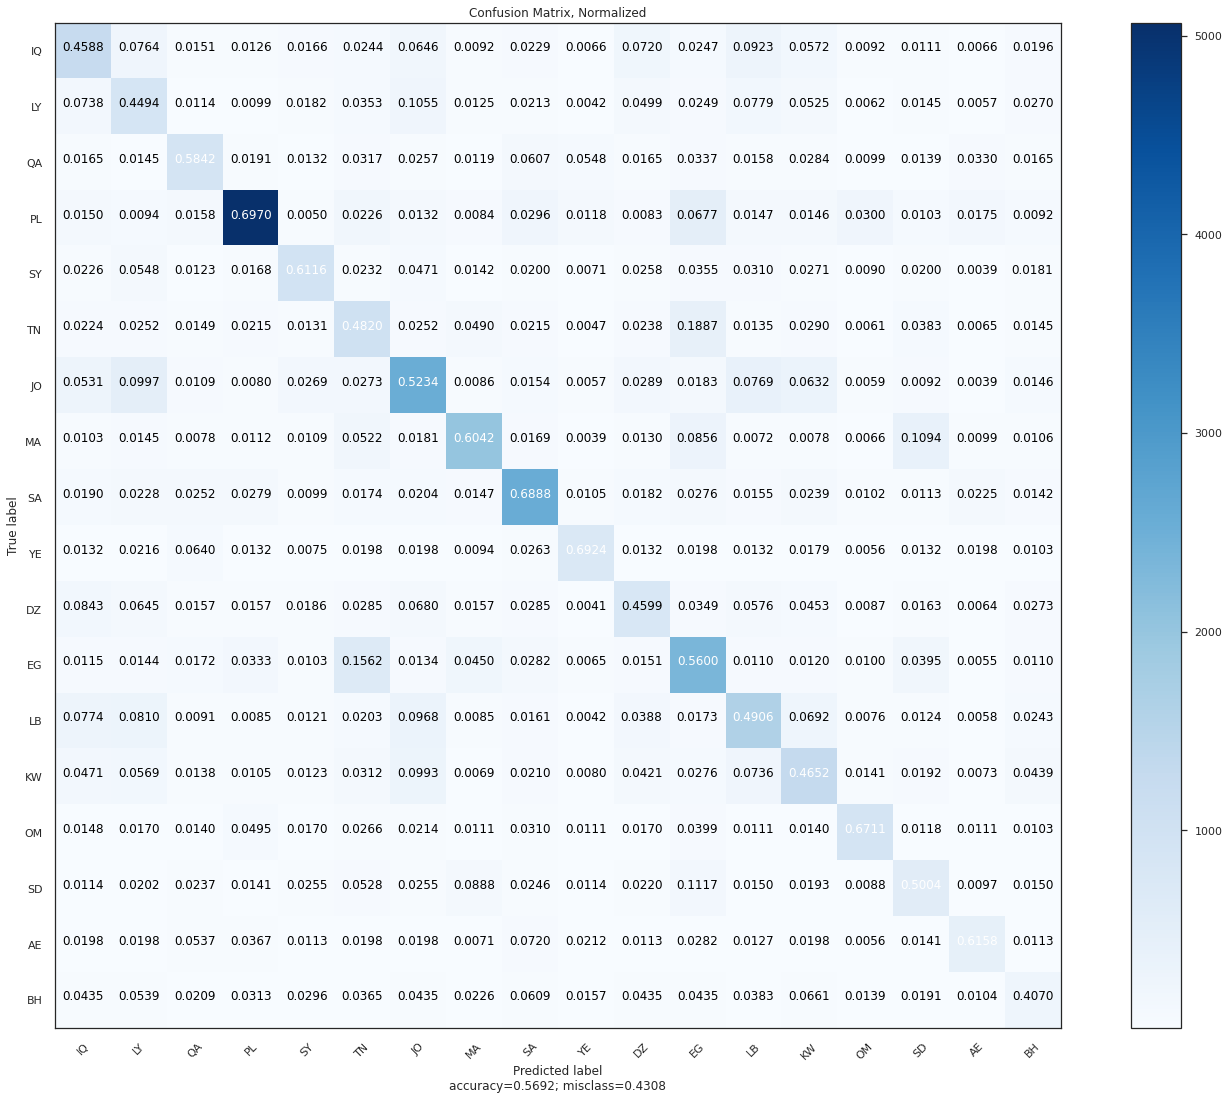

In [11]:
sns.set(font_scale=1)
sns.set(style='white')

cm = confusion_matrix(y_pred,y_test)
plot_confusion_matrix(cm           = cm, 
                      normalize    = True,
                      target_names = list(df['dialect'].unique()),
                      title        = "Confusion Matrix, Normalized")


In [12]:

print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.46      0.47      0.47      2630
           1       0.45      0.33      0.38      2629
           2       0.58      0.55      0.56      1618
           3       0.70      0.88      0.78      5764
           4       0.61      0.61      0.61      1550
           5       0.48      0.37      0.42      2792
           6       0.52      0.61      0.56      4211
           7       0.60      0.73      0.66      2762
           8       0.69      0.70      0.70      3650
           9       0.69      0.64      0.66      1154
          10       0.46      0.41      0.44      1912
          11       0.56      0.54      0.55      4374
          12       0.49      0.52      0.51      3107
          13       0.47      0.48      0.47      2683
          14       0.67      0.63      0.65      1443
          15       0.50      0.35      0.41      1624
          16       0.62      0.47      0.53       924
          17       0.41    

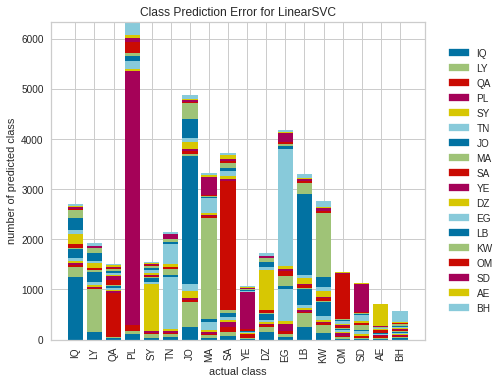

In [10]:
from yellowbrick.classifier import ClassPredictionError

# Instantiate the classification model and visualizer
visualizer = ClassPredictionError(
    model, classes=list(df.dialect.unique())
)

# Fit the training data to the visualizer
visualizer.fit(x_train,y_train)

# Evaluate the model on the test data
visualizer.score(x_test, y_test)

# Draw visualization
g = visualizer.poof()

In [13]:
joblib.dump(model,'SVM_Model_final.joblib', compress=3)


['SVM_Model_final.joblib']

In [ ]:
ml_model=joblib.load('/content/SVM_Model.joblib')


In [15]:
import shutil
shutil.copy("/content/SVM_Model_final.joblib","/content/drive/MyDrive/AIM_Task/")

'/content/drive/MyDrive/AIM_Task/SVM_Model_final.joblib'